# Project 2 - Machine Learning Modeling Overview

## Selection of dataset
Chose the Detection of IoT Botnet Attacks N-BaIoT from the UCI Machine Learning Repository:

https://archive.ics.uci.edu/dataset/442/detection+of+iot+botnet+attacks+n+baiot

It is a collection of CSV files per device, each representing benign and attack traffic captured from IoT devices. There is a folder for each device. Inside each are many csv files. Each CSV contains raw feature vectors extracted from traffic windows.

# Business Understanding

## Background
A botnet is a network of internet-connected devices (like computers, phones, IoT gadgets) that have been infected with malware and are being controlled remotely by an attacker, often without the owner's knowledge.

Bot = infected device ('robot')
Net = network
botnet = a network of infected devices working together

Botnets are used for:
DDoS attacks - they flood a website until it crashes
spam campaigns - send millions of phishing emails
data theft/keylogging - steal login credentials
crypto mining - use your device to mine crypto
click fraud - fake ad clicks for revenue
spreading malware - infect other systems

How botnets work:
1. Malware infects a device (eg. via phishing, weak passowrds, open ports)
2. device becomes a "zombie" - quietly waits for commands
3. all zombie devices are controlled by a command and control (C&C) server
4. attacker sends order to launch attacks or harvest data

IoT botnets increasingly target smart devices such as doorbells, cameras, thermostats, and baby monitors, because they often have poor security, making them easy targets.

## Dataset Details
What is the N-BaIoT dataset?
It’s a benchmark dataset created by researchers to help build and evaluate machine learning models for detecting botnet attacks on Internet of Things (IoT) devices.

Key facts:
1. Contains data from 9 IoT devices (eg. doorbell, camera, baby monitor)
2. The dataset contains traffic types, including benign and multiple botnet attack types (eg. Mirai, Bashlite)
3. Files are CSVs per device, each representing one type of behavior
4. Features are pre-extracted statistical features from raw network traffic
5. No "Label" columns, but filesnames will indicate if its benign or an attack

Purpose of dataset:
To support network-based intrusion detection systems that:
1. monitor traffic from IoT devices
2. detect abnormal patterns linked to botnet activity
3. work without needing deep packet inspection (for speed and privacy)

## Project goals
1. train a binary classifier to detect whether an IoT event is benign or attack
2. if there's enough time, train a multi-class classification to identify specific botnet families

## Project Considerations
1. labeling - no "label" column but file names will indicate benign or attack type
2. the data is highly imbalanced. 92% of the data is labeled as attack type, while only 8% is labeled as benign. This is now a severely imbalanced classification problem which can cause models to always predict "attack", and may lead to high accuracy but poor recall on minority class (benign)



# Data Understanding

In [21]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, loguniform


In [2]:
# define function to load data

def load_n_baiot_data(device_dir):
    dataframes = []
    
    # walk through the directory structure
    for root, dirs, files in os.walk(device_dir):
        for f in files:
            if f.endswith('.csv'):
                path = os.path.join(root, f)

                # determine label based on filename
                label = 'benign' if 'benign' in f.lower() else 'attack'
                print(f"Loading: {path} as {label}")
                # read the CSV file
                # use header=0 to read the first row as column names
                df = pd.read_csv(path, header=0, skiprows=0)

                # add label (benign or attack) and source file to the dataframe
                df['label'] = label
                df['source_file'] = f
                dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

# # define function to load all devices
# def load_all_devices(base_dir):
#     all_dfs = []

#     for device_name in os.listdir(base_dir):
#         device_path = os.path.join(base_dir, device_name)
#         if os.path.isdir(device_path):
#             print(f"Loading: {device_name}")
#             df = load_n_baiot_data(device_path)
#             df['device'] = device_name
#             all_dfs.append(df)

#     return pd.concat(all_dfs, ignore_index=True)

# Parallelized version of loading all devices
def load_all_devices(base_dir):
    device_paths = [
        (device_name, os.path.join(base_dir, device_name))
        for device_name in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, device_name))
    ]

    def load_device(device_info):
        device_name, device_path = device_info
        print(f"Loading: {device_name}")
        df = load_n_baiot_data(device_path)
        df['device'] = device_name
        return df

    with ThreadPoolExecutor() as executor:
        all_dfs = list(executor.map(load_device, device_paths))

    return pd.concat(all_dfs, ignore_index=True)


In [ ]:
# define the folder where the data is stored

# path for PC
base_dir = r"C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot"

# path for laptop
# base_dir = r

# load all devices data
full_df = load_all_devices(base_dir)

# cell took 18 sec to run after parallelization 7/14/25

Loading: Danmini_Doorbell
Loading: Ecobee_Thermostat
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Danmini_Doorbell\benign_traffic.csv as benign
Loading: Ennio_Doorbell
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Ecobee_Thermostat\benign_traffic.csv as benign
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Ennio_Doorbell\benign_traffic.csv as benign
Loading: Philips_B120N10_Baby_Monitor
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Philips_B120N10_Baby_Monitor\benign_traffic.csv as benign
Loading: Provision_PT_737E_Security_Camera
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Provision_PT_737E_Security_Camera\benign_traffic.csv as benign
Loading: Provision_PT_838_Security_Camera
Loading: C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot\Provision_PT_8

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7062606 entries, 0 to 7062605
Columns: 118 entries, MI_dir_L5_weight to device
dtypes: float64(115), object(3)
memory usage: 6.2+ GB


In [5]:
print("Full device dataframe shape:\n", full_df.shape)
print("\nFull device dataframe - # of observations:\n", full_df['device'].value_counts())
print("\nFull device dataframe - # of types of observations:\n", full_df['label'].value_counts())



Full device dataframe shape:
 (7062606, 118)

Full device dataframe - # of observations:
 device
Philips_B120N10_Baby_Monitor                1098677
Danmini_Doorbell                            1018298
SimpleHome_XCS7_1002_WHT_Security_Camera     863056
SimpleHome_XCS7_1003_WHT_Security_Camera     850826
Provision_PT_838_Security_Camera             836891
Ecobee_Thermostat                            835876
Provision_PT_737E_Security_Camera            828260
Samsung_SNH_1011_N_Webcam                    375222
Ennio_Doorbell                               355500
Name: count, dtype: int64

Full device dataframe - # of types of observations:
 label
attack    6506674
benign     555932
Name: count, dtype: int64


Data is highly imbalanced. Will need to use stratified splits during train_test_split. Use class weights in models like logistic regression, random forest, XGBoost

Cannot rely on accuracy. Will need to use precision, recall, f1-score, ROC-AUC, and confusion matrix

In [6]:
print("\nFull device dataframe - preview:\n", full_df.head())


Full device dataframe - preview:
    MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       60.000000            0.000000          1.000000   
1          1.000000      354.000000            0.000000          1.000000   
2          1.857879      360.458980           35.789338          1.912127   
3          1.000000      337.000000            0.000000          1.000000   
4          1.680223      172.140917        18487.448750          1.793580   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       60.000000            0.000000          1.000000       60.000000   
1      354.000000            0.000000          1.000000      354.000000   
2      360.275733           35.923972          1.969807      360.091968   
3      337.000000            0.000000          1.000000      337.000000   
4      182.560279        18928.175300          1.925828      193.165753   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpH

In [7]:
# check for missing values
missing_values = full_df.isnull().sum()[full_df.isnull().sum() > 0]
print(f"\nMissing values in each column:\n{missing_values}")


Missing values in each column:
Series([], dtype: int64)


There are no missing values in any feature columns

In [8]:
# basic statistical summary
numeric_features = full_df.select_dtypes(include = ['int64', 'float64']).columns.tolist()

print(f"Numerical feature statistics:\n{full_df[numeric_features].describe()}")

Numerical feature statistics:
       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      7.062606e+06    7.062606e+06        7.062606e+06      7.062606e+06   
mean       8.168001e+01    1.787253e+02        1.546414e+04      1.292258e+02   
std        6.894208e+01    1.653134e+02        2.410819e+04      1.093774e+02   
min        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
25%        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
50%        9.133941e+01    7.400975e+01        5.630810e+00      1.405521e+02   
75%        1.415606e+02    3.140587e+02        3.351639e+04      2.262886e+02   
max        4.380028e+02    1.452697e+03        4.918058e+05      5.586770e+02   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    7.062606e+06        7.062606e+06      7.062606e+06    7.062606e+06   
mean     1.788192e+02        1.715114e+04      3.670795e+02    1.790749e+02   
std

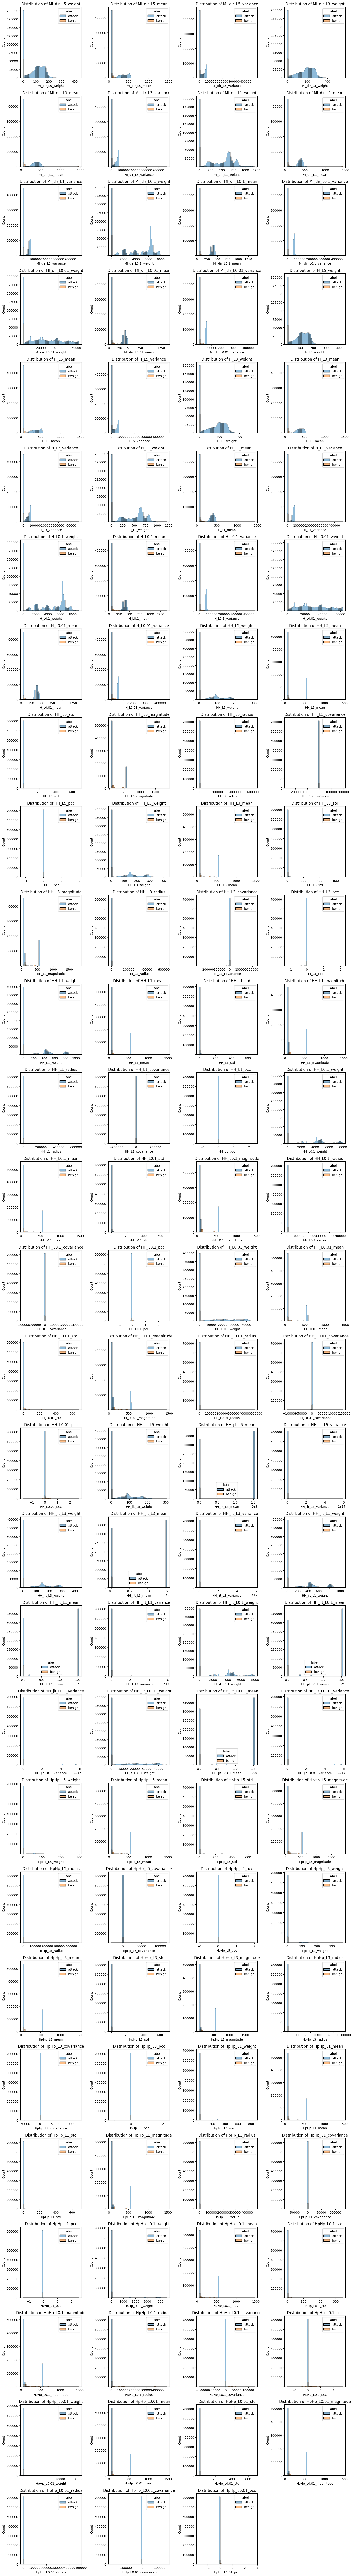

In [ ]:
# examine distribution of each numeric feature
n = len(numeric_features)
rows = int(np.ceil(n / 4))
plt.figure(figsize=(16, 4 * rows))

# plot histograms of numerical features

sample_df = full_df.sample(n=770000, random_state=42)

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, 4, i+1)
    sns.histplot(data = sample_df, x=feature, hue='label', kde=False, bins=50)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# cell took 15+ min to run on 7/14/25 with kde=True

# cell took 1m 45s to run on 7/14/25 with kde=False and sample size 770000
# memory error occurred. Need to bin  the data to reduce memory usage. set bins = 50

# cell took 1 min 16s to run with sample_df, bins=50 and kde=False. 7/14/25

# Data Preparation

In [26]:
# for logistic regression

# # raw scaled data
# raw_scaled = Pipeline([
#     ('scaler', StandardScaler())
# ])

# log-transformed data
log_transformer = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# combine both
# union_transformer = FeatureUnion([
#     ('raw', raw_scaled),
#     ('log', log_transformed)
# ])

# create transformer for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),
])

# use both raw and log transformed data for logistic regression only, not randomforest/xgboost
preprocessor_lr = ColumnTransformer(
    transformers = [
        ('log', log_transformer, numeric_features),
    ]
)

# Modeling

In [27]:
# split data into features and target

# full_df[numeric_features]
X = full_df[numeric_features]

# full_df['label'] is the target
y = full_df['label']

# encode target labels as binary (0 = benign, 1 = attack)

le = LabelEncoder()
y = le.fit_transform(full_df['label'])


In [28]:
# split into training and test sets (80% train, 20% test), use random_state=42 and set stratify = y
# random_state=42 ensures reproducibility
# stratify y to preserve class balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random forest pipeline
# random_state=42 for reproducibility
# class weight = 'balanced' to adjust for class imbalance (benign = 8%)
# n_jobs=-1 to use all available cores for parallel processing

rf_pipeline = Pipeline(steps = [
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# create logistic regression pipeline (set random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1)
# random_state=42 for reproducibility
# max_iter=1000 to ensure convergence
# class_weight='balanced' to adjust for class imbalance (benign = 8%)
# n_jobs=-1 to use all available cores for parallel processing

lr_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1))
])

# cell took 9.2 sec to run on 7/14/25

In [29]:
# define parameter search for random search

# Define multiple scoring metrics
scoring = {
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

# define parameter distributions for random forest
rf_param_distr = {
    'classifier__max_depth': randint(5, 20),  # max depth of trees
    'classifier__min_samples_split': randint(2, 20),  # min samples to split a node
    'classifier__min_samples_leaf': randint(1, 20),  # min samples at a leaf node
    'classifier__n_estimators': randint(50, 200),  # number of trees in the forest
    'classifier__class_weight': ['balanced', None],  # class weights
    'classifier__bootstrap': [True]
}

# define parameters distributions for logistic regression
lr_param_distr = {
    'classifier__C': loguniform(1e-4, 1e2),  # regularization strength
    'classifier__class_weight': ['balanced', None],  # handle imbalanced classes
    'classifier__solver': ['liblinear', 'saga']
}

# use random search to get a ballpark estimate of the best parameters
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distr,
    n_iter=20,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='precision',  # refit the model based on precision
    return_train_score=True,
    random_state=42,
    n_jobs=-1,  # use all available cores
    verbose=1  # show progress
)

# use random search to get a ballpark estimate of the best parameters for logistic regression
lr_random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_distr,
    n_iter=20,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='precision',  # refit the model based on precision
    return_train_score=True,
    random_state=42,
    n_jobs=-1,  # use all available cores
    verbose=1  # show progress
)

In [30]:
rf_random_search.fit(X_train, y_train)
lr_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


MemoryError: Unable to allocate 3.87 GiB for an array with shape (115, 4520067) and data type float64

# Exploratory Data Analysis

# Statistical Data Analysis

# Evaluation

# Conclusion